<a href="https://colab.research.google.com/github/Naveenbsm/22024816-llm/blob/main/22024816_llm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install datasets

In [ ]:
# Import necessary libraries
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [ ]:
dataset = load_dataset("yelp_review_full")
train_df = dataset['train'].to_pandas()
val_df = dataset['test'].to_pandas()


# Check the first few rows
print(train_df.head())


   label                                               text
0      4  dr. goldberg offers everything i look for in a...
1      1  Unfortunately, the frustration of being Dr. Go...
2      3  Been going to Dr. Goldberg for over 10 years. ...
3      3  Got a letter in the mail last week that said D...
4      0  I don't know what Dr. Goldberg was like before...


In [ ]:
# Check for null values
null_values = train_df.isnull().sum()

# Display the count of null values for each column
print(null_values)
print(train_df.shape)

label    0
text     0
dtype: int64
(650000, 2)


   label                                               text
0      4  dr. goldberg offers everything i look for in a...
1      1  Unfortunately, the frustration of being Dr. Go...
2      3  Been going to Dr. Goldberg for over 10 years. ...
3      3  Got a letter in the mail last week that said D...
4      0  I don't know what Dr. Goldberg was like before...
Null values in each column:
label    0
text     0
dtype: int64

Basic statistics:
               label
count  650000.000000
mean        2.000000
std         1.414215
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         4.000000


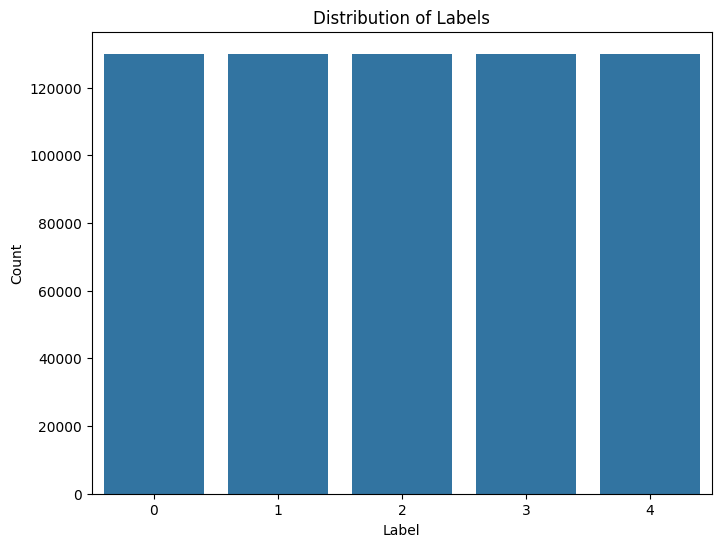

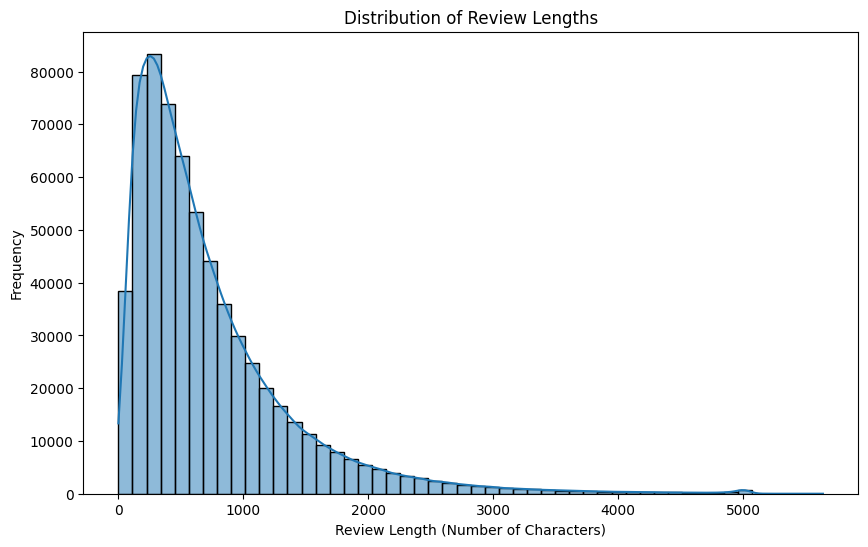

Class Distribution (Proportion):
label
4    0.2
1    0.2
3    0.2
0    0.2
2    0.2
Name: proportion, dtype: float64


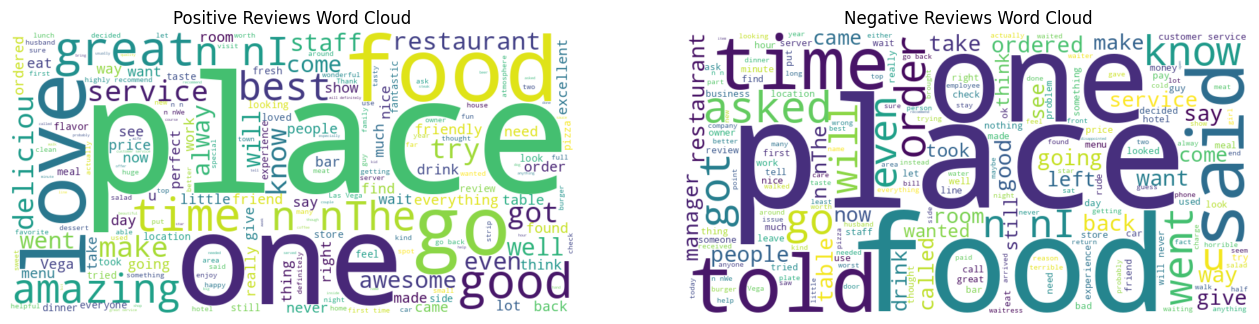

In [ ]:
# Create a copy of the training DataFrame for EDA
train_df_copy = train_df.copy()

# Display the first few rows of the copied DataFrame
print(train_df_copy.head())

# Check for null values in the copied DataFrame
null_values = train_df_copy.isnull().sum()
print("Null values in each column:")
print(null_values)

# Basic statistics of the DataFrame
print("\nBasic statistics:")
print(train_df_copy.describe())

# Distribution of the labels
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=train_df_copy)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Length of reviews (number of characters)
train_df_copy['review_length'] = train_df_copy['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(train_df_copy['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (Number of Characters)')
plt.ylabel('Frequency')
plt.show()

# Check for class imbalance
label_counts = train_df_copy['label'].value_counts(normalize=True)
print("Class Distribution (Proportion):")
print(label_counts)

# Generate word clouds for each label (assuming label 0 is negative and 4 is positive)
positive_reviews = train_df_copy[train_df_copy['label'] == 4]['text'].tolist()
negative_reviews = train_df_copy[train_df_copy['label'] == 0]['text'].tolist()

# Generate word clouds
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_reviews))
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(negative_reviews))

# Plot word clouds
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Reviews Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Reviews Word Cloud')
plt.axis('off')

plt.show()


In [ ]:
# Load the DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

# Tokenize the training and validation datasets (using a subset of data for quicker testing)
train_df = train_df.sample(20000)
val_df = val_df.sample(5000)

train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_df['text'].tolist(), truncation=True, padding=True, max_length=128)

# Convert labels to tensors
train_labels = torch.tensor(train_df['label'].values)
val_labels = torch.tensor(val_df['label'].values)

# Create a custom dataset class
class YelpReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create the dataset objects
train_dataset = YelpReviewDataset(train_encodings, train_labels)
val_dataset = YelpReviewDataset(val_encodings, val_labels)

# Set up the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="steps",
    fp16=True,  # Enable mixed precision training
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Fine-tune the model
trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-27-2b495979385b>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Step,Training Loss,Validation Loss
10,1.621800,1.612142
20,1.616500,1.606097
30,1.604200,1.597031
40,1.591800,1.582223
50,1.574300,1.539654
60,1.532100,1.455745
70,1.405200,1.339611
80,1.350700,1.323160
90,1.337500,1.257852
100,1.234300,1.233285


<ipython-input-27-2b495979385b>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
<ipython-input-27-2b495979385b>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
<ipython-input-27-2b495979385b>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
<ipython-input-27-2b495979385b>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.c

In [ ]:
# Evaluate the model
eval_results = trainer.evaluate()

# Get predictions and true labels
predictions = trainer.predict(val_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = val_labels.cpu().numpy()

# Calculate performance metrics
report = classification_report(true_labels, pred_labels, target_names=[str(i) for i in range(5)], output_dict=True)
print("Classification Report:")
print(report)

# Extract metrics
accuracy = report['accuracy']
precision = [report[str(i)]['precision'] for i in range(5)]
recall = [report[str(i)]['recall'] for i in range(5)]
f1_score = [report[str(i)]['f1-score'] for i in range(5)]

# Plot Precision, Recall, F1-Score for each class
x_labels = [str(i) for i in range(5)]
x = np.arange(len(x_labels))

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2

# Plot Precision
ax.bar(x - bar_width, precision, width=bar_width, label='Precision', color='b')

# Plot Recall
ax.bar(x, recall, width=bar_width, label='Recall', color='g')

# Plot F1-Score
ax.bar(x + bar_width, f1_score, width=bar_width, label='F1-Score', color='r')

# Set labels and titles
ax.set_xlabel('Class Labels')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-Score per Class')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()

plt.show()

# Plot confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Find the minimum length among steps, train_loss, and eval_loss
min_length = min(len(steps), len(train_loss), len(eval_loss))

# Trim all arrays to this minimum length
steps = steps[:min_length]
train_loss = train_loss[:min_length]
eval_loss = eval_loss[:min_length]

# Plotting the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(steps, train_loss, label='Training Loss', color='blue')
plt.plot(steps, eval_loss, label='Validation Loss', color='orange')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()


In [ ]:
def classify_review(review_text):
    # Check if a GPU is available, and if so, move the model to the GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Tokenize the input text and move the tensors to the same device as the model
    inputs = tokenizer(review_text, return_tensors='pt', truncation=True, padding=True, max_length=128).to(device)

    # Ensure the model is in evaluation mode
    model.eval()

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted label
    predicted_label = torch.argmax(outputs.logits, dim=1).item()

    # Map the predicted label to a sentiment category
    if predicted_label in [0, 1]:
        sentiment = "Negative"
    elif predicted_label == 2:
        sentiment = "Neutral"
    else:  # predicted_label in [3, 4]
        sentiment = "Positive"

    return sentiment

# Example test cases(Deployment)
test_reviews = [
    "The food was delicious, and the service was excellent!",
    "The restaurant was noisy, and the service was terrible.",
    "Great ambiance, but the food was just okay.",
    "Absolutely fantastic experience, highly recommended!",
    "The food was cold, and the wait was too long.",
    "The pizza was too greasy, but the staff was friendly and helpful.",
    "Amazing desserts, but the main course lacked flavor.",
    "The service was quick, but the portions were small.",
    "I loved the decor and the atmosphere, but the food could have been better.",
    "Everything was perfect, from the appetizers to the dessert!",
    "The place was overcrowded, and the food didn't live up to the hype.",
    "Decent meal, but nothing to write home about.",
    "The sushi was fresh and delicious, will definitely return!",
    "The pasta was overcooked, and the sauce was bland.",
    "Good value for money, but the waiting time was too long.",
    "I enjoyed the live music, but the food was mediocre at best.",
    "The cocktails were excellent, and the food was even better!",
    "Poor customer service, and the food was overpriced.",
    "Lovely place for a date night, with great food and ambiance.",
    "The steak was cooked to perfection, but the sides were disappointing.",
    "Too expensive for the quality of food served.",
    "Nice presentation, but the taste didn't match the looks.",
    "I had high expectations, but the restaurant failed to deliver.",
    "The seafood was fresh and flavorful, a must-visit!",
    "A bit on the pricey side, but worth it for the quality.",
    "The service was slow, but the food was worth the wait.",
    "A hidden gem with a cozy atmosphere and delicious food.",
    "The salad was fresh and tasty, but the main course was a letdown.",
    "I had a great time, the staff made us feel welcome.",
    "The portions were huge, but the food lacked seasoning."
]

# Classify each test review and print the sentiment
for review in test_reviews:
    sentiment = classify_review(review)
    print(f"Review: {review}\nPredicted Sentiment: {sentiment}\n")
